In [ ]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
#import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip /content/drive/MyDrive/AIS.zip

Streaming output truncated to the last 5000 lines.
  inflating: AIS/train_masks/train/shifted65_2_2.png  
  inflating: AIS/train_masks/train/shifted65_2_3.png  
  inflating: AIS/train_masks/train/shifted65_2_4.png  
  inflating: AIS/train_masks/train/shifted65_2_5.png  
  inflating: AIS/train_masks/train/shifted65_2_6.png  
  inflating: AIS/train_masks/train/shifted65_3_0.png  
  inflating: AIS/train_masks/train/shifted65_3_1.png  
  inflating: AIS/train_masks/train/shifted65_3_2.png  
  inflating: AIS/train_masks/train/shifted65_3_3.png  
  inflating: AIS/train_masks/train/shifted65_3_4.png  
  inflating: AIS/train_masks/train/shifted65_3_5.png  
  inflating: AIS/train_masks/train/shifted65_3_6.png  
  inflating: AIS/train_masks/train/shifted66_0_0.png  
  inflating: AIS/train_masks/train/shifted66_0_1.png  
  inflating: AIS/train_masks/train/shifted66_0_2.png  
  inflating: AIS/train_masks/train/shifted66_0_3.png  
  inflating: AIS/train_masks/train/shifted66_0_4.png  
  inflating: A

In [ ]:
import os
import numpy as np
from tensorflow.keras.metrics import MeanIoU
from tensorflow import keras
from keras import backend as K
#from cbam_unet import build_cbam_unet
#from attention_unet import build_attention_unet
from matplotlib import pyplot as plt
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model


In [ ]:
def jacard_coef(y_true, y_pred):
    y_true_f=K.flatten(y_true)
    y_pred_f=K.flatten(y_pred)
    intersection=K.sum(y_true_f*y_pred_f)
    return (intersection+1.0)/(K.sum(y_true)+K.sum(y_pred_f)-intersection+1.0)

In [ ]:
def dice_coef(y_true, y_pred, smooth=100):
    y_true_f = K.flatten(K.cast(y_true, dtype='float32'))
    #y_true_f=np.array(y_true_f, dtype=np.uint8)
    y_pred_f = K.flatten(K.cast(y_pred, dtype='float32'))
    #y_pred_f=np.array(y_pred_f, dtype=np.uint8)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
import tensorflow as tf
def focal_loss(y_true, y_pred):
	gamma=2.0
	alpha=0.25
	pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
	pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
	return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1+K.epsilon())) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))

In [ ]:
def total_loss(y_true, y_pred):
    cfe=focal_loss(y_true, y_pred)
    dl=dice_coef_loss(y_true, y_pred)
    return cfe+dl

In [ ]:
class_labels=np.load("class_label.npy")

In [ ]:
seed=24
batch_size=16
n_classes=8

from keras.utils import to_categorical
#preprocess_input=sm.get_preprocessing('resnet34')


def preprocess_data(img, mask, num_classes):
    def rgb_to_2D_label(label):
        label_seg=np.zeros(label.shape, dtype=np.uint8)
        for i, p in enumerate(class_labels,0):
            label_seg[np.all(label==p, axis=-1)]=i
        label_seg=label_seg[:,:,0]
        return label_seg
    img=img/255
    #img=tf.keras.applications.resnet.preprocess_input(img)
    labels=[]
    for i in range(mask.shape[0]):
        label=rgb_to_2D_label(mask[i])
        labels.append(label)
    labels=np.array(labels)
    labels=np.expand_dims(labels, axis=3)
    label_encoded=[]
    for i in labels:
        label_encoded.append(to_categorical([i],num_classes)[0])

    mask=np.array(label_encoded, dtype=np.uint8)
    return (img, mask)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def trainGenerator (train_img_path, train_mask_path, num_class):
    img_data_gen_args = dict(horizontal_flip=True,
    vertical_flip=True, fill_mode='reflect')
    image_datagen = ImageDataGenerator (**img_data_gen_args)
    mask_datagen = ImageDataGenerator (**img_data_gen_args)
    image_generator = image_datagen.flow_from_directory( train_img_path, class_mode=None,
    batch_size = batch_size, seed=seed)
    mask_generator = mask_datagen.flow_from_directory(train_mask_path, class_mode=None,
     batch_size = batch_size, seed = seed)
    train_generator=zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        img, mask= preprocess_data(img, mask, num_class)
        yield (img, mask)

In [ ]:
train_img_path="/content/AIS/train_images/"
train_mask_path="/content/AIS/train_masks/"
train_img_gen=trainGenerator(train_img_path, train_mask_path, num_class=8)
val_img_path="/content/AIS/val_images/"
val_mask_path="/content/AIS/val_masks/"
val_img_gen=trainGenerator(val_img_path, val_mask_path, num_class=8)

In [ ]:
x,y=train_img_gen.__next__()

StopIteration: 

In [ ]:
from matplotlib import pyplot as plt
for i in range(0,3):
    image=x[i]
    mask=np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

NameError: name 'x' is not defined

In [ ]:
num_train_imgs=len(os.listdir('/content/AIS/train_images/train'))
num_val_images=len(os.listdir('/content/AIS/val_images/val'))
steps_per_epoch=num_train_imgs//8
val_steps_per_epoch=num_val_images//8
img_height=x.shape[1]
img_width=x.shape[2]
n_classes=8


NameError: name 'x' is not defined

In [ ]:
from unet3plus import unet3plus
model=unet3plus((256, 256, 3))
metrics=['accuracy', jacard_coef]
model.compile(optimizer='adam', loss=total_loss, metrics=metrics )

ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [ ]:
history=model.fit(train_img_gen, steps_per_epoch=steps_per_epoch, epochs=50, verbose=1, validation_data=test_img_gen, validation_steps=val_steps_per_epoch, callbacks=[checkpoint_callback])
model.save('UAVid_AttUnet.hdf5')

Epoch 1/50
462/462 [==============================] - ETA: 0s - loss: -0.4376 - accuracy: 0.5672 - jacard_coef: 0.3436Found 1000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.

Epoch 1: saving model to my_model_checkpoint.01.h5
462/462 [==============================] - 408s 776ms/step - loss: -0.4376 - accuracy: 0.5672 - jacard_coef: 0.3436 - val_loss: -0.3744 - val_accuracy: 0.5085 - val_jacard_coef: 0.3059
Epoch 2/50
462/462 [==============================] - ETA: 0s - loss: -0.5331 - accuracy: 0.6413 - jacard_coef: 0.4317
Epoch 2: saving model to my_model_checkpoint.02.h5
462/462 [==============================] - 347s 753ms/step - loss: -0.5331 - accuracy: 0.6413 - jacard_coef: 0.4317 - val_loss: -0.5819 - val_accuracy: 0.6853 - val_jacard_coef: 0.4998
Epoch 3/50
462/462 [==============================] - ETA: 0s - loss: -0.5664 - accuracy: 0.6699 - jacard_coef: 0.4646
Epoch 3: saving model to my_model_checkpoint.03.h5
462/462 [===========================

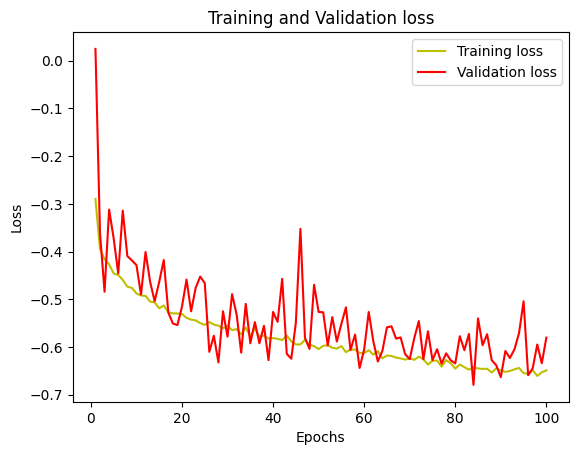

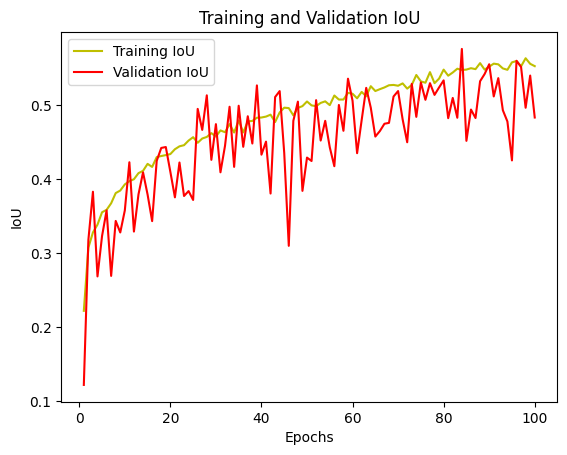

In [ ]:
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1, len(loss)+1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc=history.history['jacard_coef']
val_acc=history.history['val_jacard_coef']
plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [ ]:
history=model.fit(train_img_gen, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, validation_data=val_img_gen, validation_steps=val_steps_per_epoch, callbacks=[checkpoint_callback])
model.save('UAVid_AttUnet.hdf5')

Epoch 1/20
462/462 [==============================] - ETA: 0s - loss: -0.4083 - accuracy: 0.5364 - jacard_coef: 0.3215
Epoch 1: saving model to my_model_checkpoint.01.h5
462/462 [==============================] - 118s 254ms/step - loss: -0.4083 - accuracy: 0.5364 - jacard_coef: 0.3215 - val_loss: -0.4281 - val_accuracy: 0.5608 - val_jacard_coef: 0.3456
Epoch 2/20
 14/462 [..............................] - ETA: 1:33 - loss: -0.4246 - accuracy: 0.5494 - jacard_coef: 0.3349

KeyboardInterrupt: 

1/1 [==============================] - 0s 18ms/step


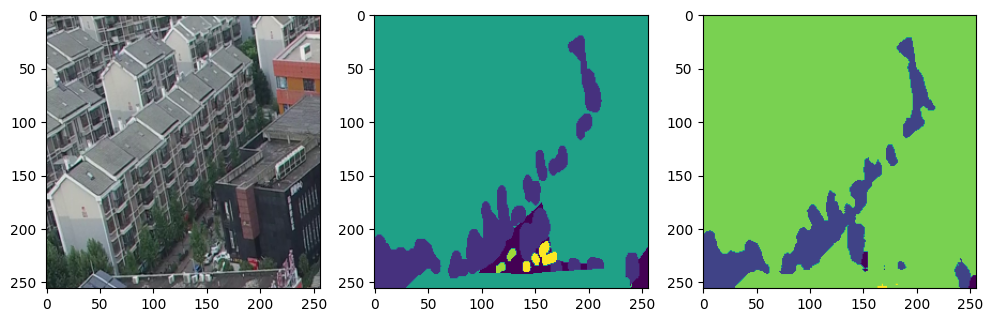

1/1 [==============================] - 0s 20ms/step


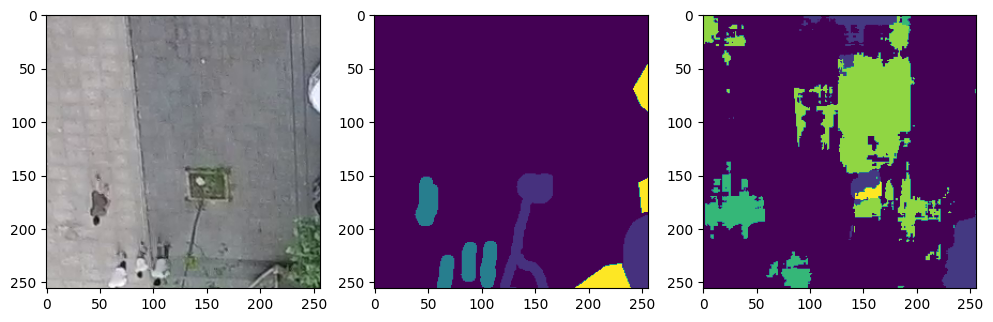

1/1 [==============================] - 0s 21ms/step


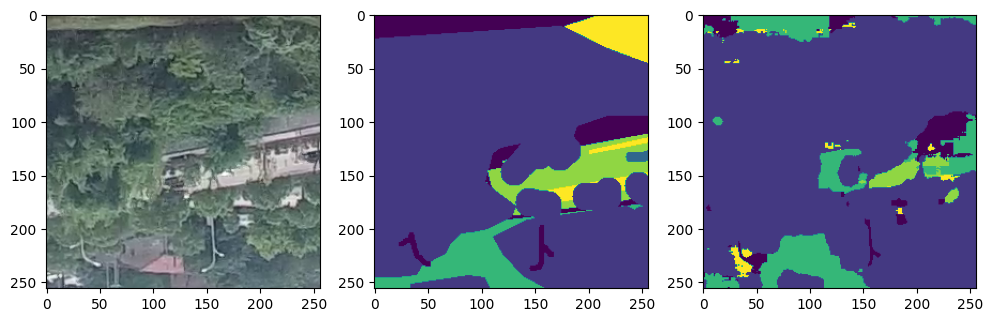

In [ ]:
x,y=train_img_gen.__next__()

from matplotlib import pyplot as plt
for i in range(0,3):
    image=x[i]
    image=np.expand_dims(image, 0)
    prediction=(model1.predict(image))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]
    mask=np.argmax(y[i], axis=2)
    plt.figure(figsize=(12,8))
    plt.subplot(231)
    plt.imshow(image[0])
    plt.subplot(232)
    plt.imshow(mask)
    plt.subplot(233)
    plt.imshow(predicted_img)
    plt.show()

In [ ]:
predicted_img

array([[5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5],
       ...,
       [5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5]], dtype=int64)

In [ ]:
np.savetxt("data.txt", predicted_img.astype(np.uint8), delimiter=",", newline="\n")

In [ ]:
x[0].shape

(256, 256, 3)

In [ ]:
import random
test_img=x[0]
ground_truth=y[0]
test_img_input=np.expand_dims(test_img, 0)
prediction=(model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
plt.figure(figsize=(12,8))
plt.subplot(231)
plt.title('Testing image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()